<a href="https://colab.research.google.com/github/AyushSoni14/PoliSentimentAnalyzer-/blob/main/PoliSentimentAnalyzer_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 21.5 MB/s eta 0:00:00


In [2]:
from selenium import webdriver

In [3]:
!apt-get install chromium-driver

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'chromium-chromedriver' instead of 'chromium-driver'
The following additional packages will be installed:
  apparmor chromium-browser libfuse3-3 libudev1 snapd squashfs-tools systemd-hwe-hwdb udev
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser chromium-chromedriver libfuse3-3 snapd squashfs-tools systemd-hwe-hwdb
  udev
The following packages will be upgraded:
  libudev1
1 upgraded, 8 newly installed, 0 to remove and 29 not upgraded.
Need to get 30.3 MB of archives.
After this operation, 123 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubuntu2.4 [598 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 squashfs-tools amd64 1:4.5-3build1 [159 kB]
Get:3 http://archive.ubuntu.com/

In [5]:
def web_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--verbose")
    options.add_argument("--no-sandbox")
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    options.add_argument("--window-size=1920,1200")
    options.add_argument("--disable-dev-shm-usage")

    driver = webdriver.Chrome(options=options)
    return driver


In [6]:
driver=web_driver()

In [14]:
# -*- coding: utf-8 -*-
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# ----------------------------
# SECTION 1: Data Loading & Preprocessing
# ----------------------------

# Sample Data (Replace with actual datasets)

congress_data = pd.read_csv("/content/YouTube comments  for Congress dataset.csv")  # CSV should have at least columns: commentText, Label
bjp_data = pd.read_csv("/content/Youtube comments for BJP dataset.csv", encoding="ISO-8859-1")
# Define political keywords
political_keywords = ['modi', 'rahul', 'bjp', 'congress']

# Function to check if comment is political
def is_political(text):
    text_lower = str(text).lower()
    return any(keyword in text_lower for keyword in political_keywords)

# Assign final labels
def assign_label(row, dataset):
    text = row['commentText']
    if not is_political(text):
        return 0  # Neutral
    else:
        if dataset == 'congress':
            return 2 if row['Label'] == 1 else 1  # Congress=2, BJP=1
        elif dataset == 'bjp':
            return 1 if row['Label'] == 1 else 2  # BJP=1, Congress=2

# Process datasets
congress_data['FinalLabel'] = congress_data.apply(assign_label, axis=1, dataset='congress')
bjp_data['FinalLabel'] = bjp_data.apply(assign_label, axis=1, dataset='bjp')

# Combine datasets
combined_data = pd.concat([congress_data, bjp_data], ignore_index=True)
X = combined_data['commentText']
y = combined_data['FinalLabel']

# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------
# SECTION 2: MLP with TF-IDF
# ----------------------------

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Build MLP model
model_mlp = Sequential()
model_mlp.add(Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(256, activation='relu'))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(3, activation='softmax'))
model_mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train MLP
model_mlp.fit(X_train_tfidf.toarray(), y_train_cat, epochs=10, batch_size=64, validation_split=0.1)

# Evaluate MLP
loss, accuracy = model_mlp.evaluate(X_test_tfidf.toarray(), y_test_cat)
print(f"MLP Test Accuracy: {accuracy*100:.2f}%")

# ----------------------------
# SECTION 3: LSTM with Embedding
# ----------------------------

# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(5000, 128, input_length=max_len))
model_lstm.add(LSTM(128, dropout=0.2))
model_lstm.add(Dense(3, activation='softmax'))
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train LSTM
model_lstm.fit(X_train_pad, y_train_cat, epochs=10, batch_size=64, validation_split=0.1)

# Evaluate LSTM
loss, accuracy = model_lstm.evaluate(X_test_pad, y_test_cat)
print(f"LSTM Test Accuracy: {accuracy*100:.2f}%")

# ----------------------------
# SECTION 4: CNN-LSTM
# ----------------------------

# Build CNN-LSTM model
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Embedding(5000, 128, input_length=max_len))
model_cnn_lstm.add(Conv1D(64, 5, activation='relu'))
model_cnn_lstm.add(MaxPooling1D(pool_size=4))
model_cnn_lstm.add(LSTM(128))
model_cnn_lstm.add(Dense(3, activation='softmax'))
model_cnn_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train CNN-LSTM
model_cnn_lstm.fit(X_train_pad, y_train_cat, epochs=10, batch_size=64, validation_split=0.1)

# Evaluate CNN-LSTM
loss, accuracy = model_cnn_lstm.evaluate(X_test_pad, y_test_cat)
print(f"CNN-LSTM Test Accuracy: {accuracy*100:.2f}%")

# ----------------------------
# SECTION 5: Prediction Function
# ----------------------------

def predict_comment(comment):
    # Step 1: Check if political
    if not is_political(comment):
        return "Neutral"
    else:
        # Step 2: Predict using MLP model (can replace with other models)
        comment_vec = tfidf.transform([comment])
        prediction = model_mlp.predict(comment_vec.toarray())
        predicted_class = np.argmax(prediction)
        return ["Neutral", "BJP Supported", "Congress Supported"][predicted_class]

# Example usage
test_comment = "Modi is the best leader"
print(predict_comment(test_comment))  # Output: BJP Supported

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.4544 - loss: 1.0578 - val_accuracy: 0.7405 - val_loss: 0.7211
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8092 - loss: 0.5690 - val_accuracy: 0.8544 - val_loss: 0.4047
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9249 - loss: 0.2382 - val_accuracy: 0.8449 - val_loss: 0.3767
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9610 - loss: 0.1480 - val_accuracy: 0.8418 - val_loss: 0.3760
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9686 - loss: 0.1110 - val_accuracy: 0.8386 - val_loss: 0.4006
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9774 - loss: 0.0865 - val_accuracy: 0.8323 - val_loss: 0.4239
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9814 - loss: 0.0776 - val_accuracy: 0.8513 - val_loss: 0.4630
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9845 - loss: 0.0572 - val_accuracy: 0.8449 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 429ms/step - accuracy: 0.4626 - loss: 1.0426 - val_accuracy: 0.7342 - val_loss: 0.6165
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 328ms/step - accuracy: 0.7698 - loss: 0.5486 - val_accuracy: 0.8038 - val_loss: 0.4142
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 371ms/step - accuracy: 0.8484 - loss: 0.3577 - val_accuracy: 0.8449 - val_loss: 0.3635
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 346ms/step - accuracy: 0.9041 - loss: 0.2517 - val_accuracy: 0.8639 - val_loss: 0.3697
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - accuracy: 0.9367 - loss: 0.1781 - val_accuracy: 0.8544 - val_loss: 0.3720
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - accuracy: 0.9508 - loss: 0.1484 - val_accuracy: 0.8671 - val_loss: 0.4031
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 344ms/step - accuracy: 0.9646 - loss: 0.1137 - val_accuracy: 0.8671 - val_loss: 0.4199
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step - accuracy: 0.9713 - loss: 0.0993 - val_accuracy: 0.841

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


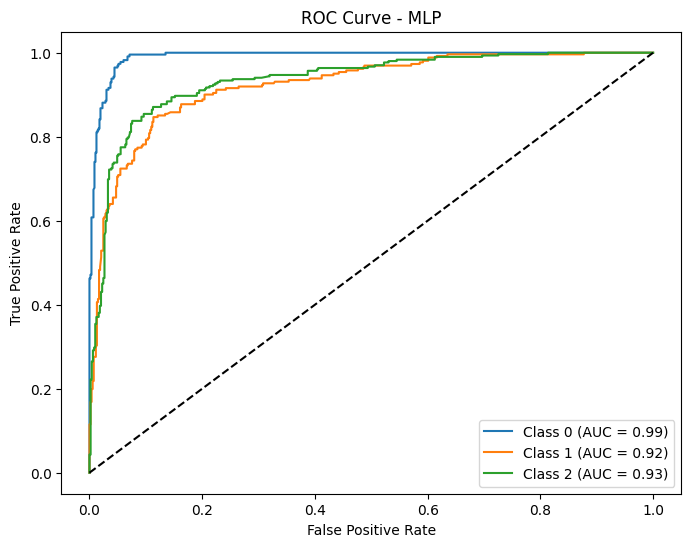

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step


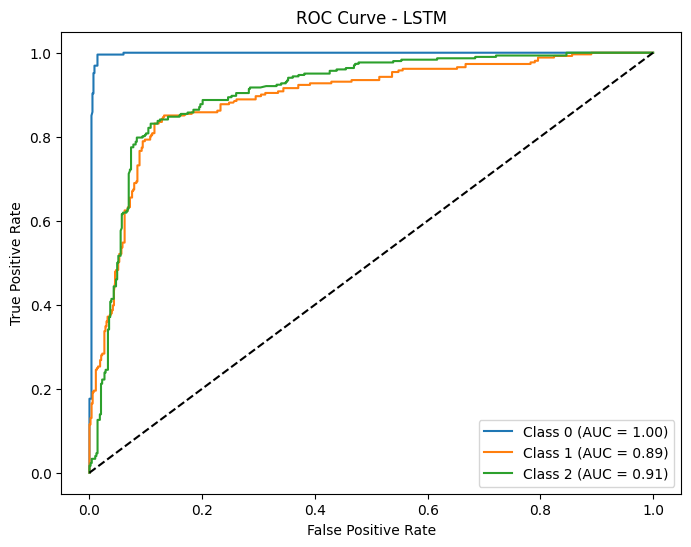

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


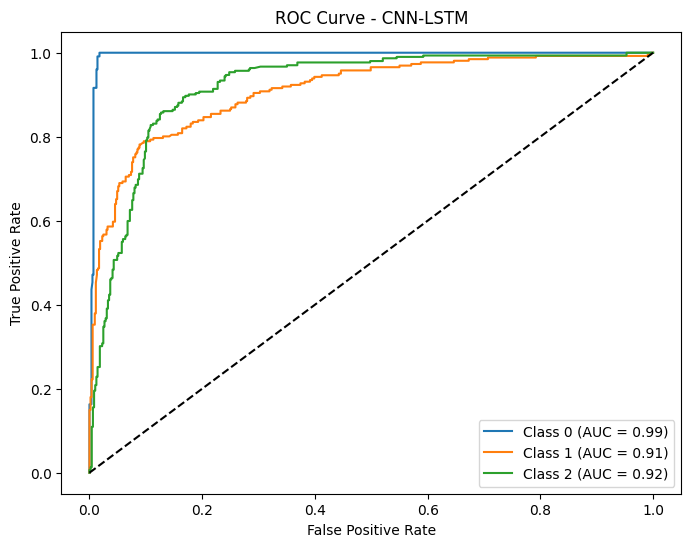

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ----------------------------
# SECTION 6: ROC Curve and Evaluation Metrics
# ----------------------------

def plot_roc_curve(y_true, y_pred_probs, model_name):
    """Plots ROC Curve"""
    plt.figure(figsize=(8, 6))
    for i in range(3):  # Since we have 3 classes
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

# MLP Model ROC Curve
y_pred_mlp = model_mlp.predict(X_test_tfidf.toarray())
plot_roc_curve(y_test_cat, y_pred_mlp, "MLP")

# LSTM Model ROC Curve
y_pred_lstm = model_lstm.predict(X_test_pad)
plot_roc_curve(y_test_cat, y_pred_lstm, "LSTM")

# CNN-LSTM Model ROC Curve
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test_pad)
plot_roc_curve(y_test_cat, y_pred_cnn_lstm, "CNN-LSTM")


In [15]:
import time
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

def web_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--verbose")
    options.add_argument("--no-sandbox")
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    options.add_argument("--window-size=1920,1200")
    options.add_argument("--disable-dev-shm-usage")

    driver = webdriver.Chrome(options=options)
    return driver

def get_youtube_comments(video_url, max_comments=10):
    driver = web_driver()
    print(f"Opening YouTube video: {video_url}")
    driver.get(video_url)
    time.sleep(5)  # Allow the page to load

    print("Scrolling to comments section...")
    driver.execute_script("window.scrollTo(0, 600);")  # Scroll down
    time.sleep(3)

    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "ytd-comment-thread-renderer #content-text"))
    )

    comments = []
    scroll_attempts = 0
    last_comment_count = 0

    while len(comments) < max_comments and scroll_attempts < 100:
        elements = driver.find_elements(By.CSS_SELECTOR, "ytd-comment-thread-renderer #content-text")

        for element in elements[len(comments):]:
            comment_text = element.text.strip()
            if comment_text:
                comments.append(comment_text)
                print(f"✅ Extracted {len(comments)}: {comment_text[:50]}...")
                if len(comments) >= max_comments:
                    break

        driver.execute_script("window.scrollBy(0, 400);")
        time.sleep(2)

        if len(comments) == last_comment_count:
            scroll_attempts += 1
            if scroll_attempts >= 100:
                print("⚠️ No more comments loading after multiple scrolls. Stopping...")
                break
        last_comment_count = len(comments)

    driver.quit()
    return comments

video_url = "https://youtu.be/CWAeRoXANUk?si=_-8O_SGAJVAmyMCj"
comments = get_youtube_comments(video_url, max_comments=200)

if comments:
    with open("youtube_comments.csv", "w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Comment"])
        for comment in comments:
            writer.writerow([comment])

    print(f"✅ Saved {len(comments)} comments to youtube_comments.csv")
else:
    print("❌ No comments extracted.")

Opening YouTube video: https://youtu.be/CWAeRoXANUk?si=_-8O_SGAJVAmyMCj
Scrolling to comments section...
✅ Extracted 1: Drug addiction is not only Kerala problem but toda...
✅ Extracted 2: An energetic and sincere straight looking positive...
✅ Extracted 3: Rahui Gandhi ️️️️️...
✅ Extracted 4: By watching Rahul Gandhi's interaction with varied...
✅ Extracted 5: Thank you RGfrom Kerala...
✅ Extracted 6: Its amazing that they actually mentioned upfirst t...
✅ Extracted 7: Great Rahul...
✅ Extracted 8: Ye hai real Kerala story 
I love you Rahul Gandhi ...
✅ Extracted 9: Thank you Rahul ji for putting the spotlight on tw...
✅ Extracted 10: Make Next  PM RAHUL GANDHI...
✅ Extracted 11: joy rahul ji...
✅ Extracted 12: Thank you for addressing a relevant topic from ker...
✅ Extracted 13: The great visionary leader rahulji....
✅ Extracted 14: GODBLESS RAHUL HIS FAMILY HIS CHANNEL!...
✅ Extracted 15: thanks for speaking on drug issue, we need strict ...
✅ Extracted 16: Great RG...
✅ Extracted 1

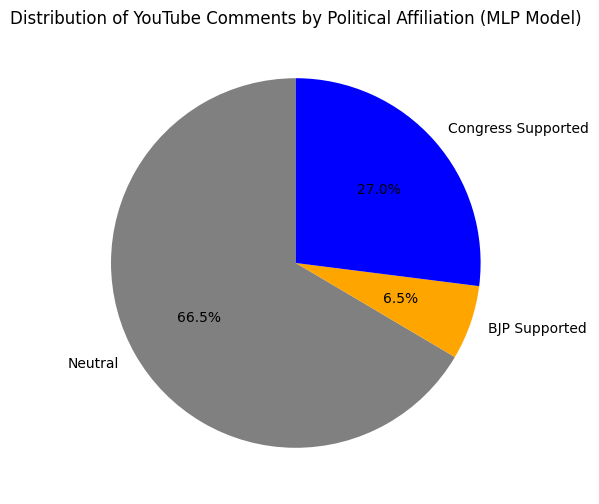

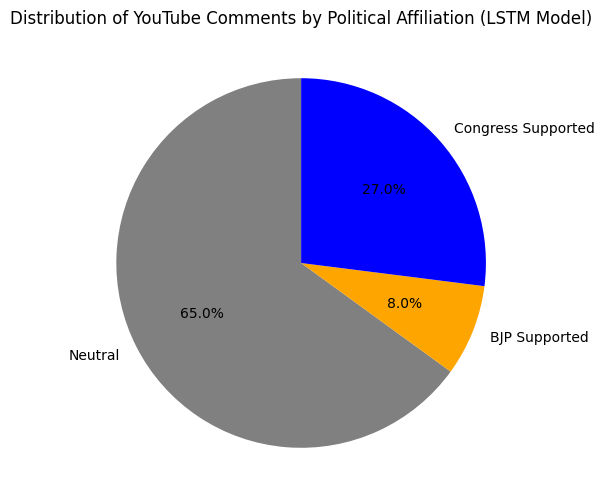

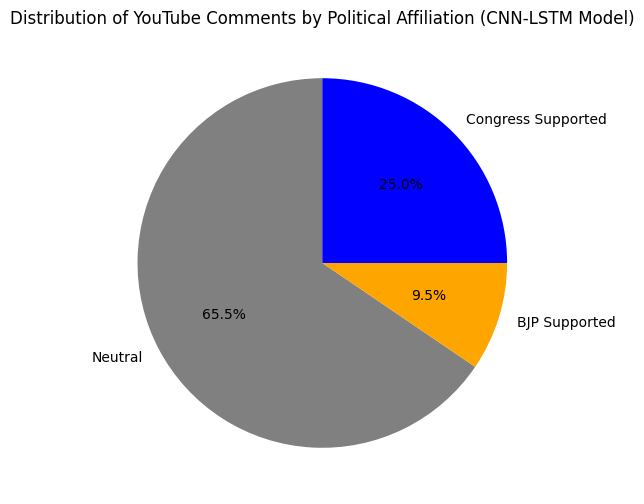

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from keras.preprocessing.sequence import pad_sequences

# Load the dataset
df = pd.read_csv("youtube_comments.csv")

# Initialize counters for all models
default_counts = {"bjp": 0, "congress": 0, "neutral": 0}
counts_mlp = default_counts.copy()
counts_lstm = default_counts.copy()
counts_cnn_lstm = default_counts.copy()

# Function to predict comment category for each model
def predict_comment(comment, model, vectorizer, counts, model_type="mlp"):
    if not is_political(comment):
        counts["neutral"] += 1
        return "Neutral"
    else:
        if model_type == "mlp":
            comment_vec = vectorizer.transform([comment]).toarray()
        else:  # LSTM & CNN-LSTM require tokenization and padding
            comment_seq = vectorizer.texts_to_sequences([comment])
            comment_vec = pad_sequences(comment_seq, maxlen=100)

        prediction = model.predict(comment_vec,verbose=0)
        predicted_class = np.argmax(prediction)

        if predicted_class == 1:
            counts["bjp"] += 1
        elif predicted_class == 2:
            counts["congress"] += 1
        else:
            counts["neutral"] += 1

        return ["Neutral", "BJP Supported", "Congress Supported"][predicted_class]

# Apply prediction for each model
df["Prediction_MLP"] = df["Comment"].apply(lambda x: predict_comment(x, model_mlp, tfidf, counts_mlp, "mlp"))
df["Prediction_LSTM"] = df["Comment"].apply(lambda x: predict_comment(x, model_lstm, tokenizer, counts_lstm, "lstm"))
df["Prediction_CNN_LSTM"] = df["Comment"].apply(lambda x: predict_comment(x, model_cnn_lstm, tokenizer, counts_cnn_lstm, "cnn_lstm"))

# Save updated results
df.to_csv("youtube_comments_predicted.csv", index=False)

# Function to plot pie charts
def plot_pie_chart(counts, model_name):
    sizes = [counts["neutral"], counts["bjp"], counts["congress"]]
    if sum(sizes) == 0:
        print(f"No valid data to plot for {model_name}.")
    else:
        labels = ["Neutral", "BJP Supported", "Congress Supported"]
        colors = ["gray", "orange", "blue"]
        plt.figure(figsize=(6, 6))
        plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90)
        plt.title(f"Distribution of YouTube Comments by Political Affiliation ({model_name})")
        plt.show()

# Plot separate pie charts for each model
plot_pie_chart(counts_mlp, "MLP Model")
plot_pie_chart(counts_lstm, "LSTM Model")
plot_pie_chart(counts_cnn_lstm, "CNN-LSTM Model")